# Classification using TF-IDF

In [1]:
#Importing python packages
import numpy as np
import pandas as pd
import re
import string

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn_evaluation.plot import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV

import time
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [2]:
#Importing data file
news = pd.read_csv('News Aggregator/uci-news-aggregator.csv')
news.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1.394470e+12
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1.394470e+12
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1.394470e+12
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1.394470e+12
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1.394470e+12


In [3]:
news.count()

ID           422406
TITLE        422406
URL          422406
PUBLISHER    422404
CATEGORY     422406
STORY        422406
HOSTNAME     422406
TIMESTAMP    422406
dtype: int64

In [4]:
news.CATEGORY.value_counts()

e    152462
b    115964
t    108341
m     45639
Name: CATEGORY, dtype: int64

In [5]:
news.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1.394470e+12
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1.394470e+12
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1.394470e+12
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1.394470e+12
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1.394470e+12


In [6]:
news.tail()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
422401,422933,Surgeons to remove 4-year-old's rib to rebuild...,http://www.cbs3springfield.com/story/26378648/...,WSHM-TV,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.cbs3springfield.com,1.409230e+12
422402,422934,Boy to have surgery on esophagus after battery...,http://www.wlwt.com/news/boy-to-have-surgery-o...,WLWT Cincinnati,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.wlwt.com,1.409230e+12
422403,422935,Child who swallowed battery to have reconstruc...,http://www.newsnet5.com/news/local-news/child-...,NewsNet5.com,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.newsnet5.com,1.409230e+12
422404,422936,Phoenix boy undergoes surgery to repair throat...,http://www.wfsb.com/story/26368078/phoenix-boy...,WFSB,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.wfsb.com,1.409230e+12
422405,422937,Phoenix boy undergoes surgery to repair throat...,http://www.cbs3springfield.com/story/26368078/...,WSHM-TV,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.cbs3springfield.com,1.409230e+12


In [7]:
#Converting categories as balanced
num_of_categories = 45639 #45639
shuffled = news.reindex(np.random.permutation(news.index))
e = shuffled[shuffled['CATEGORY'] == 'e'][:num_of_categories]
b = shuffled[shuffled['CATEGORY'] == 'b'][:num_of_categories]
t = shuffled[shuffled['CATEGORY'] == 't'][:num_of_categories]
m = shuffled[shuffled['CATEGORY'] == 'm'][:num_of_categories]
concated = pd.concat([e,b,t,m], ignore_index=True)
#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))

In [8]:
concated.count()

ID           182556
TITLE        182556
URL          182556
PUBLISHER    182556
CATEGORY     182556
STORY        182556
HOSTNAME     182556
TIMESTAMP    182556
dtype: int64

In [9]:
concated.CATEGORY.value_counts()

t    45639
e    45639
b    45639
m    45639
Name: CATEGORY, dtype: int64

In [10]:
concated.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
40268,89858,Peaches Geldof death 'not suspicious',http://www.stuff.co.nz/entertainment/9915635/P...,Auckland stuff.co.nz,e,dbkX8-vtewxCqcMTbv2ELSzyqzFNM,www.stuff.co.nz,1.396940e+12
122700,224362,YouTube Makes $1B Play for Game Streaming Site...,http://newsok.com/youtube-makes-1b-play-for-ga...,NewsOK.com,t,d7ygfGk3Nqp8X4Mb77zfVrO2tAcXM,newsok.com,1.400580e+12
159665,55801,Alli Recall: Foreign Pills Found in Bottles of...,http://www.kolotv.com/home/headlines/Foreign-P...,KOLO,m,dl06z0LSB6LB4LM7M4_3GX6WUrvIM,www.kolotv.com,1.395970e+12
180407,28448,Woman told to 'cover up' in gym because toned ...,http://newsok.com/woman-told-to-cover-up-in-gy...,NewsOK.com,m,dHtARnI3D2cdbyMcD3S_v2qOP1nFM,newsok.com,1.395340e+12
83294,230339,Moscow says Russian troops leaving positions n...,http://www.dailysabah.com/europe/2014/05/21/mo...,Daily Sabah,b,dUMUefLsWyac8iMK0AjZjjzMKcA8M,www.dailysabah.com,1.400680e+12


In [11]:
# remove duplicates
concated = concated.drop_duplicates()
concated.isnull().sum()

ID           0
TITLE        0
URL          0
PUBLISHER    0
CATEGORY     0
STORY        0
HOSTNAME     0
TIMESTAMP    0
dtype: int64

In [12]:
concated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182556 entries, 40268 to 15280
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ID         182556 non-null  int64  
 1   TITLE      182556 non-null  object 
 2   URL        182556 non-null  object 
 3   PUBLISHER  182556 non-null  object 
 4   CATEGORY   182556 non-null  object 
 5   STORY      182556 non-null  object 
 6   HOSTNAME   182556 non-null  object 
 7   TIMESTAMP  182556 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 12.5+ MB


In [13]:
#Addting 2 columns as feature
concated['text'] = concated.TITLE + " " + concated.PUBLISHER
concated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182556 entries, 40268 to 15280
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ID         182556 non-null  int64  
 1   TITLE      182556 non-null  object 
 2   URL        182556 non-null  object 
 3   PUBLISHER  182556 non-null  object 
 4   CATEGORY   182556 non-null  object 
 5   STORY      182556 non-null  object 
 6   HOSTNAME   182556 non-null  object 
 7   TIMESTAMP  182556 non-null  float64
 8   text       182556 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 13.9+ MB


In [14]:
# Drop null
concated= concated.dropna(subset=['text'])

In [15]:
concated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182556 entries, 40268 to 15280
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ID         182556 non-null  int64  
 1   TITLE      182556 non-null  object 
 2   URL        182556 non-null  object 
 3   PUBLISHER  182556 non-null  object 
 4   CATEGORY   182556 non-null  object 
 5   STORY      182556 non-null  object 
 6   HOSTNAME   182556 non-null  object 
 7   TIMESTAMP  182556 non-null  float64
 8   text       182556 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 13.9+ MB


In [16]:
concated.text.iloc[86]

'Netflix Does a Bad Deal With Verizon Motley Fool'

In [17]:
concated['text'].dropna(inplace=True)

In [18]:
concated.text.iloc[86]

'Netflix Does a Bad Deal With Verizon Motley Fool'

In [19]:
symbols = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', 
           ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', 
           '#', '*', '+', '\\', '•',  '~', '@', '£', '·', '_', 
           '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', 
           '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', 
           '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', 
           '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', 
           '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', 
           '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', 
           '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', 
           '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', 
           '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', 
           '¹', '≤', '‡', '√', ]

In [20]:
def clean_symbol(text):
    text = str(text)
    for symbol in symbols:
        text = text.replace(symbol, '')
    return text

# remove symbols and punctuations 
concated['text'] = concated['text'].apply(lambda x: clean_symbol(x))

In [21]:
def clean_text(s):
    s = re.sub("[0-9]+", "",s)
    s = re.sub(' +',' ', s)
    return s

# remove numbers and special characters
concated['text'] = [clean_text(s) for s in concated['text']]

In [22]:
concated.text.iloc[86]

'Netflix Does a Bad Deal With Verizon Motley Fool'

In [23]:
# Dictionary of short form words and mispellings
short_forms_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                    "'cause": "because", "could've": "could have", "couldn't": "could not", 
                    "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
                    "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                    "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                    "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
                    "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                    "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                    "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", 
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                    "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", 
                    "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", 
                    "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", 
                    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                    "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", 
                    "that's": "that is", "there'd": "there would", "there'd've": "there would have", 
                    "there's": "there is", "here's": "here is","they'd": "they would", 
                    "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
                    "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", 
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", 
                    "we'll've": "we will have", "we're": "we are", "we've": "we have", 
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                    "what're": "what are",  "what's": "what is", "what've": "what have", 
                    "when's": "when is", "when've": "when have", "where'd": "where did", 
                    "where's": "where is", "where've": "where have", "who'll": "who will", 
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
                    "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                    "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
                    "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
                    "you're": "you are", "you've": "you have"}

In [24]:
def clean_shortforms(text):
    clean_text = text
    for shortform in short_forms_dict.keys():
        if re.search(shortform, text):
            clean_text = re.sub(shortform, short_forms_dict[shortform], text)
    return clean_text

# fix short forms
concated['text'] = concated['text'].apply(lambda x: clean_shortforms(x))

In [25]:
concated['text'] = concated['text'].str.replace('[^\w\s]','')# unpunctuate

In [26]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [27]:
count_vect = TfidfVectorizer(tokenizer = spacy_tokenizer)#, ngram_range=(1,2))

X = count_vect.fit_transform(concated['text'])

y = concated['CATEGORY']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=True) # 30% split

Naive Bayes

In [29]:
# fit and score the bayesian classifier
mnb = MultinomialNB(alpha=1)
mnb.fit(X_train, y_train)
y_pred_test_mnb=mnb.predict(X_test)
a=accuracy_score(y_pred_test_mnb, y_test)*100
print ('Test Accuracy',a)
y_pred_train_mnb=mnb.predict(X_train)
b=accuracy_score(y_train, y_pred_train_mnb)*100
print ('Train Accuracy',b)

results_mnb_cv = cross_val_score(mnb, X_train, y_train, cv=10)
print('Cross Validation Accuracy',results_mnb_cv.mean()*100)

Test Accuracy 91.76328811145397
Train Accuracy 93.50257064379564
Cross Validation Accuracy 91.69411951108208


In [30]:
print(classification_report(y_test, y_pred_test_mnb))

              precision    recall  f1-score   support

           b       0.89      0.89      0.89     13784
           e       0.95      0.94      0.95     13693
           m       0.93      0.94      0.94     13651
           t       0.90      0.90      0.90     13639

    accuracy                           0.92     54767
   macro avg       0.92      0.92      0.92     54767
weighted avg       0.92      0.92      0.92     54767



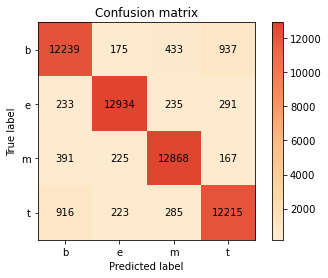

In [31]:
confusion_matrix(y_test, y_pred_test_mnb, target_names = ['b','e','m','t']).grid(False)

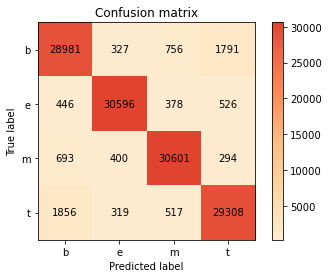

In [32]:
confusion_matrix(y_train, y_pred_train_mnb, target_names = ['b','e','m','t']).grid(False)

Logistic Regression

In [33]:
# First create the base model to tune
logreg = LogisticRegression(n_jobs=-1,solver='newton-cg',penalty='l2',multi_class='multinomial',class_weight='balanced',random_state=8)

# Fit the random search model
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=-1,
                   penalty='l2', random_state=8, solver='newton-cg', tol=0.0001,
                   verbose=0, warm_start=False)

In [34]:
y_pred_log_test = logreg.predict(X_test)
y_pred_log_train = logreg.predict(X_train)
#results_log_cv = cross_val_score(logreg, X_train, y_train, cv=5)

# Model Accuracy
print("Logistic Test Accuracy:", accuracy_score(y_test, y_pred_log_test)*100)
print("Logistic Train Accuracy:", accuracy_score(y_train, y_pred_log_train)*100)
#print('Cross Validation Accuracy',results_log_cv.mean()*100)

Logistic Test Accuracy: 93.34088045720964
Logistic Train Accuracy: 95.70307303445523


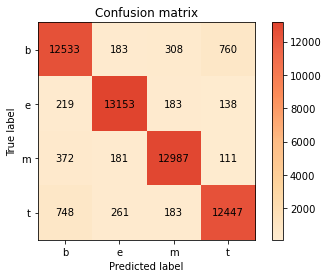

In [35]:
# Test Confusion Matrix
confusion_matrix(y_test, y_pred_log_test, target_names = ['b','e','m','t']).grid(False)

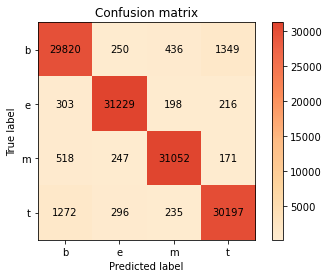

In [36]:
# Train Confusion Matrix
confusion_matrix(y_train, y_pred_log_train, target_names = ['b','e','m','t']).grid(False)

In [37]:
print(classification_report(y_test, y_pred_log_test))

              precision    recall  f1-score   support

           b       0.90      0.91      0.91     13784
           e       0.95      0.96      0.96     13693
           m       0.95      0.95      0.95     13651
           t       0.93      0.91      0.92     13639

    accuracy                           0.93     54767
   macro avg       0.93      0.93      0.93     54767
weighted avg       0.93      0.93      0.93     54767



SGD Classifier

In [38]:
from sklearn.linear_model import SGDClassifier
sgd_grid = SGDClassifier(n_jobs=-1, max_iter=15,alpha=0.00001,verbose=True)
sgd_grid.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1


Norm: 109.30, NNZs: 21347, Bias: -1.040801, T: 127789, Avg. loss: 0.179670
Total training time: 0.16 seconds.
-- Epoch 2Norm: 107.54, NNZs: 20949, Bias: -0.648424, T: 127789, Avg. loss: 0.105420

Total training time: 0.17 seconds.
-- Epoch 2
Norm: 106.92, NNZs: 20007, Bias: -0.944482, T: 127789, Avg. loss: 0.116443
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 113.72, NNZs: 22778, Bias: -0.921870, T: 127789, Avg. loss: 0.204581
Total training time: 0.12 seconds.
-- Epoch 2
Norm: 96.00, NNZs: 24592, Bias: -0.632560, T: 255578, Avg. loss: 0.057501
Total training time: 0.23 seconds.
-- Epoch 3
Norm: 101.93, NNZs: 26317, Bias: -0.839274, T: 255578, Avg. loss: 0.125030
Norm: 97.22, NNZs: 24843, Bias: -0.875826, T: 255578, Avg. loss: 0.108430Total training time: 0.18 seconds.

Total training time: 0.23 seconds.
-- Epoch 3
-- Epoch 3
Norm: 95.81, NNZs: 23514, Bias: -0.828355, T: 255578, Avg. loss: 0.065672
Total training time: 0.21 seconds.
--

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.3s finished


SGDClassifier(alpha=1e-05, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=15,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=True, warm_start=False)

In [39]:
y_pred_sgd_test = sgd_grid.predict(X_test)
y_pred_sgd_train = sgd_grid.predict(X_train)
#results_sgd_cv = cross_val_score(sgd_grid, X_train, y_train, cv=5)

# Model Accuracy
print("SGD Test Accuracy:", accuracy_score(y_test, y_pred_sgd_test)*100)
print("SGD Train Accuracy:", accuracy_score(y_train, y_pred_sgd_train)*100)
#print('Cross Validation Accuracy',results_sgd_cv.mean()*100)

SGD Test Accuracy: 94.10046195701791
SGD Train Accuracy: 96.36118914773571


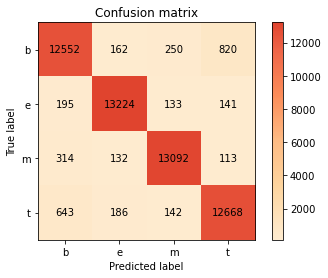

In [40]:
# Test confusion matrix
confusion_matrix(y_test, y_pred_sgd_test, target_names = ['b','e','m','t']).grid(False)

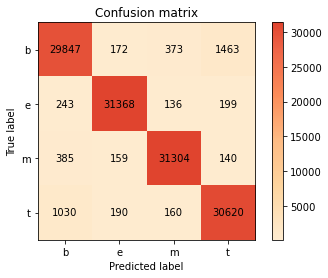

In [41]:
# Train Confusion matrix
confusion_matrix(y_train, y_pred_sgd_train, target_names = ['b','e','m','t']).grid(False)

In [42]:
print(classification_report(y_test, y_pred_sgd_test))

              precision    recall  f1-score   support

           b       0.92      0.91      0.91     13784
           e       0.96      0.97      0.97     13693
           m       0.96      0.96      0.96     13651
           t       0.92      0.93      0.93     13639

    accuracy                           0.94     54767
   macro avg       0.94      0.94      0.94     54767
weighted avg       0.94      0.94      0.94     54767



Testing

In [43]:
# title-category function
def title_to_category(title):
    title=clean_text(title)
    categories = {'b' : 'business', 
                  't' : 'science and technology', 
                  'e' : 'entertainment', 
                  'm' : 'health'}
    pridicter = logreg.predict(count_vect.transform([title]))
    return categories[pridicter[0]]

In [44]:
# testing today's headline from Irish Times
title_to_category("Samsung to pay Apple $539 million in iPhone patent case")
# link to article: https://www.irishtimes.com/news/world/europe/french-hospital-discovers-it-had-case-of-coronavirus-in-december-1.4245275

'science and technology'

In [45]:
# title-category function
def title_to_category2(title):
    title=clean_text(title)
    categories = {'b' : 'business', 
                  't' : 'science and technology', 
                  'e' : 'entertainment', 
                  'm' : 'health'}
    pridicter2 = sgd_grid.predict(count_vect.transform([title]))
    return categories[pridicter2[0]]

In [46]:
# testing today's headline from Irish Times
title_to_category2("Samsung to pay Apple $539 million in iPhone patent case")
# link to article: https://www.irishtimes.com/news/world/europe/french-hospital-discovers-it-had-case-of-coronavirus-in-december-1.4245275

'science and technology'

In [47]:
# title-category function
def title_to_category4(title):
    title=clean_text(title)
    categories = {'b' : 'business', 
                  't' : 'science and technology', 
                  'e' : 'entertainment', 
                  'm' : 'health'}
    pridicter4 = mnb.predict(count_vect.transform([title]))
    return categories[pridicter4[0]]

In [48]:
# testing today's headline from Irish Times
title_to_category4("Samsung to pay Apple $539 million in iPhone patent case")
# link to article: https://www.irishtimes.com/news/world/europe/french-hospital-discovers-it-had-case-of-coronavirus-in-december-1.4245275

'science and technology'